# Week 1: Statistical Validation of RAG Improvements

> **Prerequisites**: Complete `1. synthetic_questions_logfire.ipynb` and `2. benchmark_retrieval_logfire.ipynb` first to generate our evaluation dataset and retrieval results.

When improving RAG systems, seeing better metrics isn't enough - we need confidence that these improvements are real and reproducible. Many teams invest significant resources into complex optimizations only to discover their gains were statistical noise.

This notebook provides practical techniques to validate your RAG improvements with statistical rigor.

## Why This Matters

Consider this scenario: Your team spends a month implementing a sophisticated re-ranking system that shows a 2% improvement in recall. But is this gain meaningful, or just random variation?

Statistical validation helps you:

1. Avoid investing in unreliable "improvements"
2. Quantify confidence in performance differences
3. Make informed architectural decisions

## What You'll Learn

Through hands-on analysis of our Text-to-SQL retrieval experiments, you'll master three key validation techniques:

1. **Bootstrapping Analysis**

   - Simulate multiple experimental runs
   - Understand result stability
   - Estimate improvement reliability

2. **Confidence Intervals**

   - Visualize performance ranges
   - Interpret overlapping intervals
   - Compare approaches systematically

3. **Statistical Testing**
   - Apply t-tests to validate differences
   - Determine statistical significance
   - Make data-driven decisions

By the end of this notebook, you'll have a solid understanding of how to validate your RAG improvements and understand the impact of different techniques on your system's performance.


## Simulating Multiple Runs with Bootstrapping

> **Important** : Please replace the Span IDs below with the Span IDs you'd like to compare it with. These are the runs in our specific logfire account at the moment which will probably throw an error if you try to run it without changing the code.

We want to have code that's easily adaptable if we want to compare the results of different experiments. A good approach is to define a configuration class that we can easily scale to other experiments as seen below. This makes adding new experiments to compare as simple as adding a new configuration object.

Because we've logged our experiment results with logfire, it's easy to fetch the results. We're currently using the experimental 


In [57]:
from dataclasses import dataclass
from logfire.experimental.query_client import LogfireQueryClient
import os


def process_row(row):
    score_dict = row['attributes']
    return {
        'labels': score_dict['expected_output'],
        'preds':score_dict['output']
    }

@dataclass
class ExperimentConfig:
    span_id: str
    label: str

    def get_results(self):        
        query = f"""
        SELECT attributes FROM records
        WHERE
        parent_span_id = '{self.span_id}';
        """
        with LogfireQueryClient(read_token=os.getenv("LOGFIRE_READ_TOKEN")) as query_client:
            results = query_client.query_json_rows(sql=query)
            return [process_row(item) for item in results["rows"]]



configs = [
    ExperimentConfig(
        span_id="ec899242dabfffc1",
        label="text-embedding-3-small",
    ),
    ExperimentConfig(
        span_id="802335263550ce8b",
        label="text-embedding-3-large",
    ),
]

In [58]:
# Define some helper functions to calculate mrr and recall


def calculate_mrr(predictions: list[str], gt: list[str]):
    mrr = 0
    for label in gt:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    # Calculate the proportion of relevant items that were retrieved
    return len([label for label in gt if label in predictions]) / len(gt)


metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]
k = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

In [59]:
import numpy as np
import pandas as pd


def bootstrap_samples(config: ExperimentConfig, n_samples: int = 1000):
    means_list = []
    stds_list = []
    items = config.get_results()

    # Sample with replacement n_samples times
    for _ in range(n_samples):
        sample = np.random.choice(items, size=len(items), replace=True)

        sample_scores = []

        # For each sample, we treat it as a new experiment and compute the metrics we care about
        for row in sample:
            row_scores = {}
            for metric_name, metric_fn in metrics:
                for subset_k in k:
                    metric_key = f"{metric_name}@{subset_k}"
                    row_scores[metric_key] = metric_fn(
                        row["preds"][:subset_k], row["labels"]
                    )
            sample_scores.append(row_scores)

        # We then use this to compute means and standard deviations for each metric
        sample_df = pd.DataFrame(sample_scores)
        means_list.append(sample_df.mean().to_dict())
        stds_list.append(sample_df.std().to_dict())

    # Finally we return a dataframe of means and standard deviations for each metric
    means_df = pd.DataFrame(means_list)
    stds_df = pd.DataFrame(stds_list)

    return means_df, stds_df

## Visualising Confidence intervals

We want to see if the differences are statistically significant. The easiest way to do so is to plot the confidence interval for our bootstrapped results and see if they overlap.

If we have a large confidence interval, we might need to increase the number of trials we're running in our experiment. But if our confidence intervals overlap, then we should be worried about the difference in performance between the two models. This is because there is a chance ti might be due to chance.


In [60]:
from dataclasses import dataclass
from typing import Dict


@dataclass
class BootstrapResults:
    label: str
    means: Dict[str, float]
    stds: Dict[str, float]
    ci_lower: Dict[str, float]
    ci_upper: Dict[str, float]


def calculate_bootstrap_stats(
    means_df: pd.DataFrame, stds_df: pd.DataFrame, label: str
) -> BootstrapResults:
    """Calculate bootstrap statistics for a given experiment config"""
    # Calculate mean and confidence intervals for each metric
    results = {}
    ci_lower = {}
    ci_upper = {}
    stds = {}

    # For each metric column
    for col in means_df.columns:
        results[col] = means_df[col].mean()
        stds[col] = stds_df[col].std()
        ci_lower[col] = np.percentile(means_df[col], 2.5)
        ci_upper[col] = np.percentile(means_df[col], 97.5)

    return BootstrapResults(
        means=results,
        ci_lower=ci_lower,
        ci_upper=ci_upper,
        label=label,
        stds=stds,
    )

In [61]:
bootstrap_dfs = [bootstrap_samples(config, n_samples=1000) for config in configs]
bootstrap_results = [
    calculate_bootstrap_stats(dfs[0], dfs[1], config.label)
    for dfs, config in zip(bootstrap_dfs, configs)
]

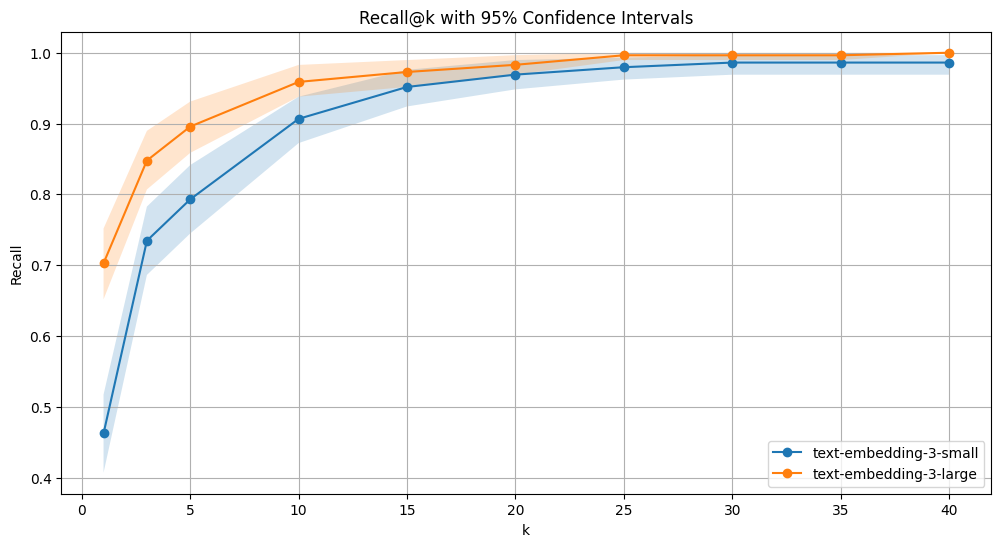

In [62]:
import matplotlib.pyplot as plt
from typing import List


def plot_recall_at_k(bootstrap_results: List[BootstrapResults]):
    plt.figure(figsize=(12, 6))

    # Extract k values from the metrics in the first result
    k_values = []
    for key in bootstrap_results[0].means.keys():
        if key.startswith("recall@"):
            k = int(key.split("@")[1])
            k_values.append(k)
    k_values.sort()

    for results in bootstrap_results:
        # Extract recall metrics
        recall_means = [results.means[f"recall@{k}"] for k in k_values]
        recall_lower = [results.ci_lower[f"recall@{k}"] for k in k_values]
        recall_upper = [results.ci_upper[f"recall@{k}"] for k in k_values]

        # Plot line and confidence interval
        plt.plot(k_values, recall_means, marker="o", label=results.label)
        plt.fill_between(k_values, recall_lower, recall_upper, alpha=0.2)

    plt.xlabel("k")
    plt.ylabel("Recall")
    plt.title("Recall@k with 95% Confidence Intervals")
    plt.grid(True)
    plt.legend()


# Plot the results
plot_recall_at_k(bootstrap_results)

We can see that for recall@k, the confidence intervals don't overlap for k = 1,3,5,10. Thereafter, as the value of k increases, the confidence intervals overlap more. However, since the values are extremely close to 1, we can't conclusively state that the two methods are not statistically significant.


In [64]:
# Calculate variances for each bootstrap result
variances_list = []
for i, result in enumerate(bootstrap_results):
    variances = {metric: f"{std**2:.5f}" for metric, std in result.stds.items()}
    variances["model"] = result.label
    variances_list.append(variances)

# Combine into single dataframe
pd.DataFrame(variances_list).set_index("model")

,recall@1,recall@3,recall@5,recall@10,recall@15,recall@20,recall@25,recall@30,recall@35,recall@40,mrr@1,mrr@3,mrr@5,mrr@10,mrr@15,mrr@20,mrr@25,mrr@30,mrr@35,mrr@40
model,,,,,,,,,,,,,,,,,,,,
text-embedding-3-small,0.00001,0.00019,0.00031,0.00059,0.00073,0.00084,0.00086,0.00105,0.00105,0.00105,0.00001,0.00007,0.00007,0.00006,0.00005,0.00005,0.00005,0.00005,0.00005,0.00005
text-embedding-3-large,0.00014,0.00044,0.00057,0.00075,0.00082,0.00096,0.00138,0.00138,0.00138,0.00000,0.00014,0.00023,0.00021,0.00017,0.00016,0.00016,0.00015,0.00015,0.00015,0.00015


## Are the means statistically different?

We want to determine if we should be worried about the overlap in our confidence intervals above. We can do so by performing a t-test between the two models for each metric. This tells us the probability that the difference in the means of the two models is due to chance.

If we have a high p-value and a low t-statistic, we can be confident that the difference in the means of the two models is due to chance. We use our bootstrap means here so that we're comparing the distributions of the means rather than the means themselves.


In [75]:
from scipy import stats

bootstrap_means = [item[0] for item in bootstrap_dfs]
# Get the first two bootstrap results
result1, result2 = bootstrap_means

# Perform t-test between the two models for each metric
t_test_results = {}

for metric in result1.keys():
    # Extract values for both models for this metric
    values_model1 = np.array(result1[metric])
    values_model2 = np.array(result2[metric])

    # Check if values are nearly identical
    if np.allclose(values_model1, values_model2, rtol=1e-10):
        print(
            f"Warning: Values for {metric} are nearly identical, t-test results may be unreliable"
        )
        t_test_results[metric] = {"t_statistic": np.nan, "p_value": np.nan}
        continue

    # Perform related t-test
    t_stat, p_value = stats.ttest_rel(values_model1, values_model2)

    t_test_results[metric] = {"t_statistic": t_stat, "p_value": p_value}

# Convert to DataFrame for better visualization
t_test_df = pd.DataFrame(t_test_results).transpose()
print("T-test results between models:")
print(t_test_df)

T-test results between models:

t_statistic        p_value
recall@1   -199.506567   0.000000e+00
recall@3   -110.184298   0.000000e+00
recall@5   -109.070894   0.000000e+00
recall@10   -79.577061   0.000000e+00
recall@15   -41.698604  6.357340e-221
recall@20   -33.818455  1.016191e-167
recall@25   -58.271082  9.881313e-324
recall@30   -41.153640  2.587138e-217
recall@35   -41.153640  2.587138e-217
recall@40   -63.395748   0.000000e+00
mrr@1      -199.506567   0.000000e+00
mrr@3      -183.372871   0.000000e+00
mrr@5      -187.479467   0.000000e+00
mrr@10     -190.911401   0.000000e+00
mrr@15     -190.059275   0.000000e+00
mrr@20     -190.543869   0.000000e+00
mrr@25     -191.195041   0.000000e+00
mrr@30     -191.066634   0.000000e+00
mrr@35     -191.066634   0.000000e+00
mrr@40     -191.231412   0.000000e+00

## Conclusion

Our t-test analysis revealed large negative t-statistics and extremely small p-values (p < 0.001) across all metrics, comparing text-embedding-3-small to text-embedding-3-large, indicating that the larger model's superior performance is statistically significant and not due to chance.

In Week 1, we built a complete RAG evaluation framework across three notebooks: generating synthetic test questions, benchmarking retrieval strategies (pure embedding vs hybrid search), and validating improvements with statistical techniques like bootstrapping and t-tests. This systematic approach ensures our improvements are real and reproducible before investing engineering resources.

These retrieval metrics will guide us through Week 2's exploration of embedding fine-tuning and beyond - from query understanding with BERTopic (Week 4), to structured data handling (Week 5), and tool selection (Week 6). Each of these improvements will be validated using these same metrics, allowing us to quantity the impact of each technique with objective metrics.
